In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
!conda list | grep pillow

pillow                    7.2.0            py37h718be6c_1    conda-forge


In [3]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [4]:
# !conda list | grep tensorflow
# !pip install tensorflow_datasets

In [5]:
import tensorflow_datasets as tfds

tfds.__version__

'3.2.1'

### cat and dog 데이터셋
https://www.tensorflow.org/datasets/catalog/cats_vs_dogs

In [6]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [7]:
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


- 이미지가 여러 shape를 가질 경우, 이미지 데이터의 크기는 (None, None, 3)로 출력된다

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

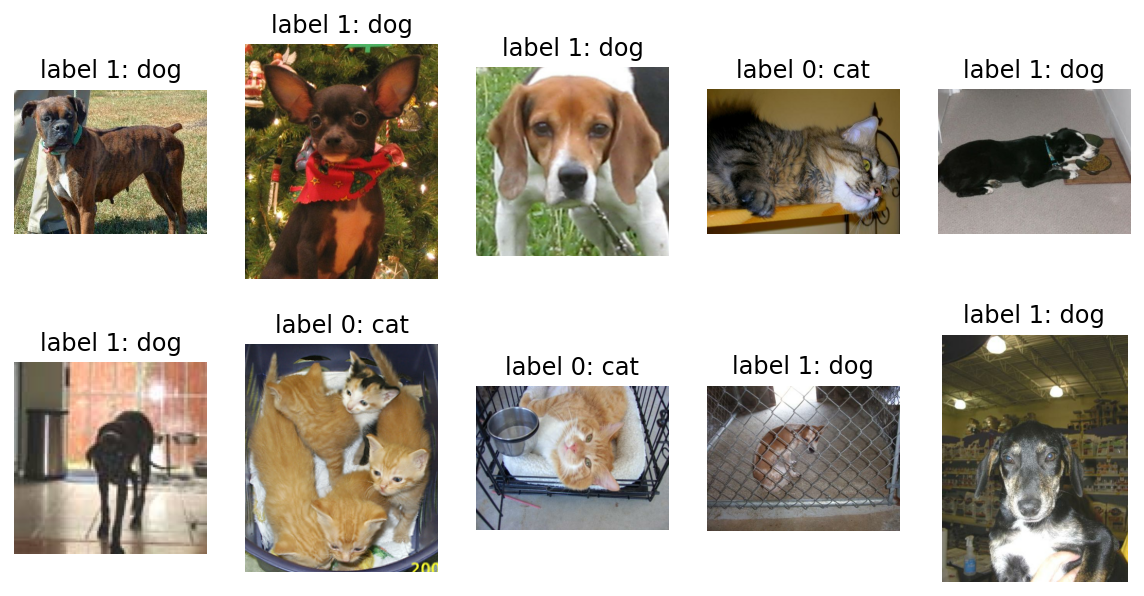

In [9]:
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [10]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [11]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

- list에 map 적용하기

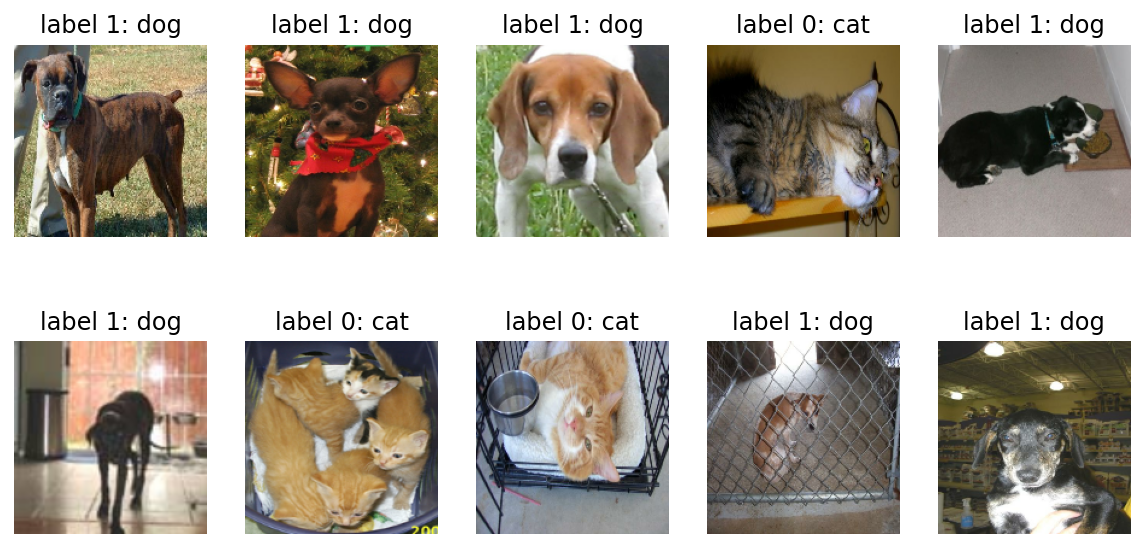

In [12]:
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

### 모델 구현

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

In [14]:
model = Sequential([
    Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(160, 160, 3)),
    MaxPooling2D(),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(units=512, activation='relu'),
    Dense(units=2, activation='softmax')
])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 160, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 25600)             0

- none은 batchsize를 의미
- 이미지는 모델을 지나면서 1차원으로 펼쳐지게 됨

In [16]:
import numpy as np

image = np.array([[1, 2], [3, 4]])
print(image.shape)
image

(2, 2)


array([[1, 2],
       [3, 4]])

In [17]:
image.flatten()

array([1, 2, 3, 4])

In [18]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

- optimizer : 오차함수를 최적화하는 함수
- loss : 모델이 학습하는 방향을 결정
- metrics : 모델 성능을 평가하는 척도(accuracy, precision, recall)

In [19]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

- batch_size = 한 step에 학습시킬 개수
- shuffle_buffer_size = 학습데이터를 섞어줄 떄 사용하는 버퍼사이즈   
    한번에 뽑는 데이터 수.   
    한번에 shuffle_buffer_size만큼 뽑고, 그 중 일부를 랜덤하게 선택함

In [20]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [21]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape, label_batch.shape

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

In [22]:
validation_steps = 20
loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 0s 14ms/step - loss: 0.6885 - accuracy: 0.5297
initial loss: 0.69
initial accuracy: 0.53


In [23]:
EPOCHS = 10
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 35s 60ms/step - loss: 0.5903 - accuracy: 0.6820 - val_loss: 0.5289 - val_accuracy: 0.7412
Epoch 2/10
582/582 [==============================] - 20s 34ms/step - loss: 0.4720 - accuracy: 0.7724 - val_loss: 0.4860 - val_accuracy: 0.7721
Epoch 3/10
582/582 [==============================] - 20s 34ms/step - loss: 0.4041 - accuracy: 0.8171 - val_loss: 0.4873 - val_accuracy: 0.7812
Epoch 4/10
582/582 [==============================] - 20s 34ms/step - loss: 0.3506 - accuracy: 0.8464 - val_loss: 0.6469 - val_accuracy: 0.7077
Epoch 5/10
582/582 [==============================] - 20s 34ms/step - loss: 0.2983 - accuracy: 0.8761 - val_loss: 0.4798 - val_accuracy: 0.7936
Epoch 6/10
582/582 [==============================] - 22s 37ms/step - loss: 0.2436 - accuracy: 0.9026 - val_loss: 0.5333 - val_accuracy: 0.7885
Epoch 7/10
582/582 [==============================] - 21s 37ms/step - loss: 0.1967 - accuracy: 0.9240 - val_loss: 0.5154 - val_accuracy:

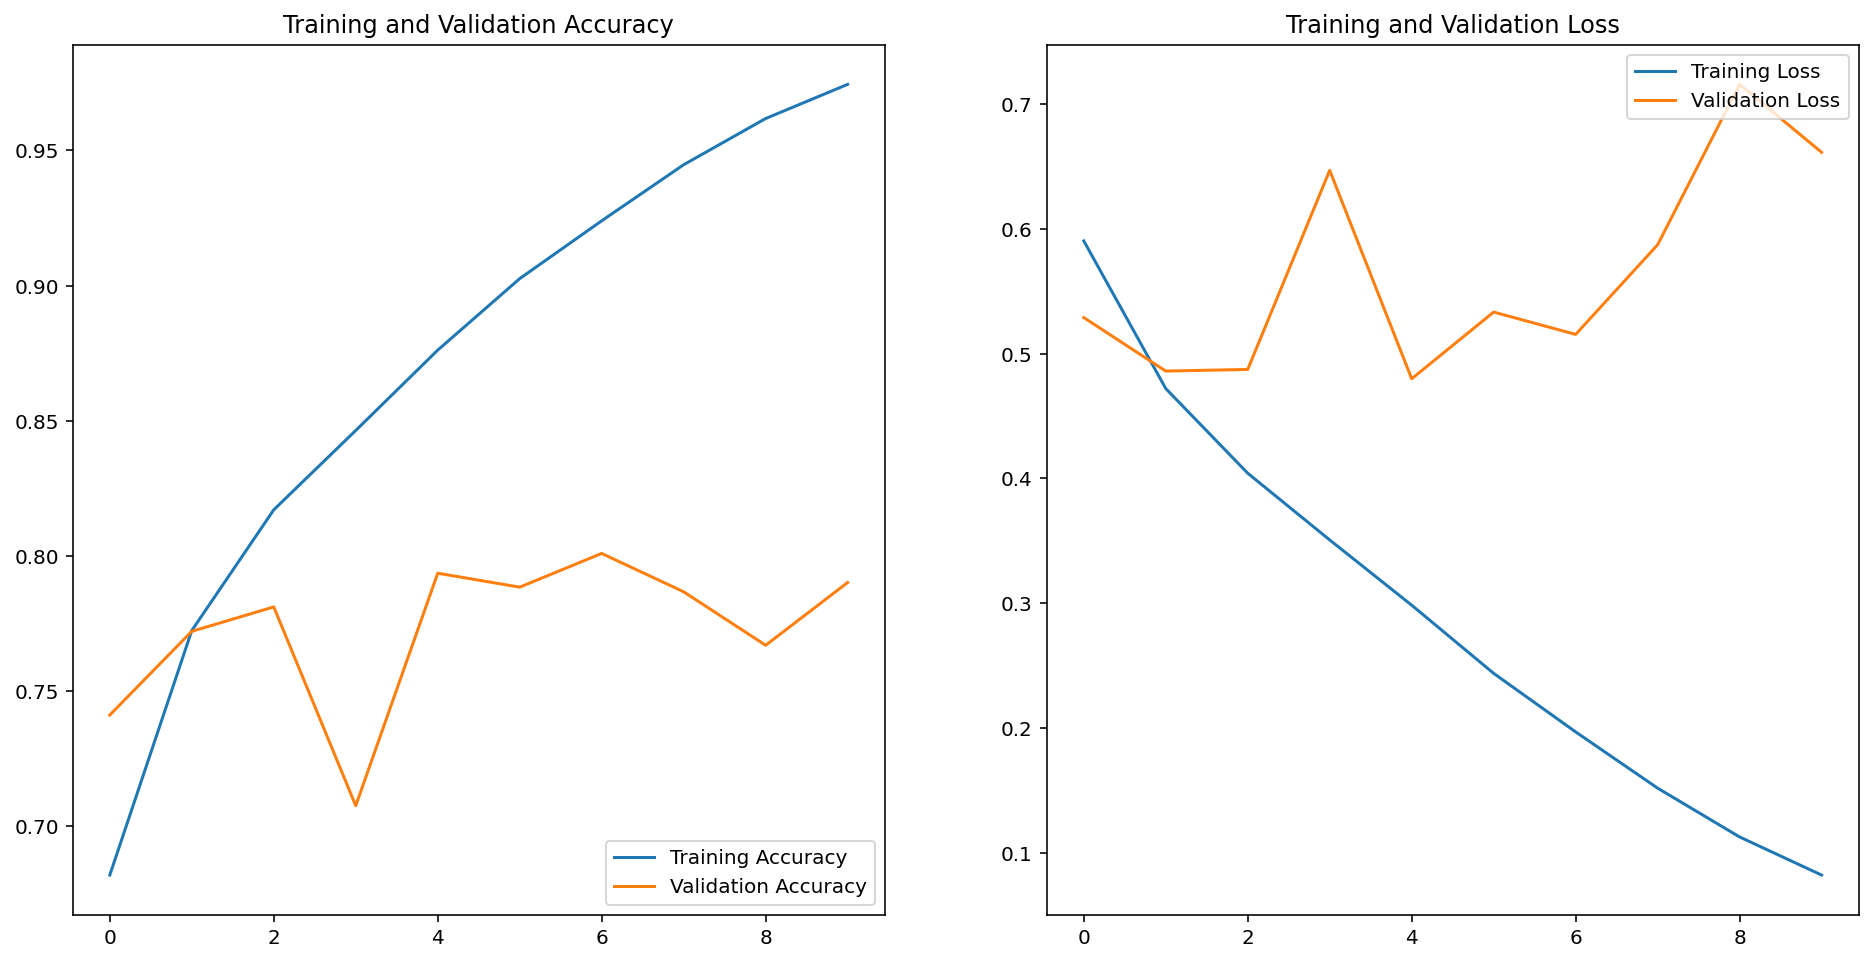

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[9.9999845e-01, 1.5866354e-06],
       [8.4778148e-01, 1.5221852e-01],
       [4.7122166e-01, 5.2877837e-01],
       [9.9999809e-01, 1.9274160e-06],
       [1.7955191e-02, 9.8204482e-01],
       [3.3109438e-01, 6.6890562e-01],
       [7.4996627e-03, 9.9250036e-01],
       [9.8086393e-01, 1.9136069e-02],
       [7.3931269e-02, 9.2606866e-01],
       [4.1132319e-01, 5.8867681e-01],
       [3.2123573e-02, 9.6787637e-01],
       [9.9954396e-01, 4.5603892e-04],
       [9.9164069e-01, 8.3592562e-03],
       [1.8990157e-03, 9.9810106e-01],
       [9.9526286e-01, 4.7371173e-03],
       [9.9316543e-01, 6.8345987e-03],
       [8.2953876e-01, 1.7046121e-01],
       [2.2615384e-05, 9.9997735e-01],
       [9.5183289e-01, 4.8167117e-02],
       [9.9678421e-01, 3.2158147e-03],
       [9.8209333e-01, 1.7906718e-02],
       [8.4866208e-01, 1.5133789e-01],
       [9.9850911e-01, 1.4908512e-03],
       [9.9432158e-01, 5.6783524e-03],
       [9.9785513e-01, 2.1448068e-03],
       [1.3460320e-02, 9.

In [26]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

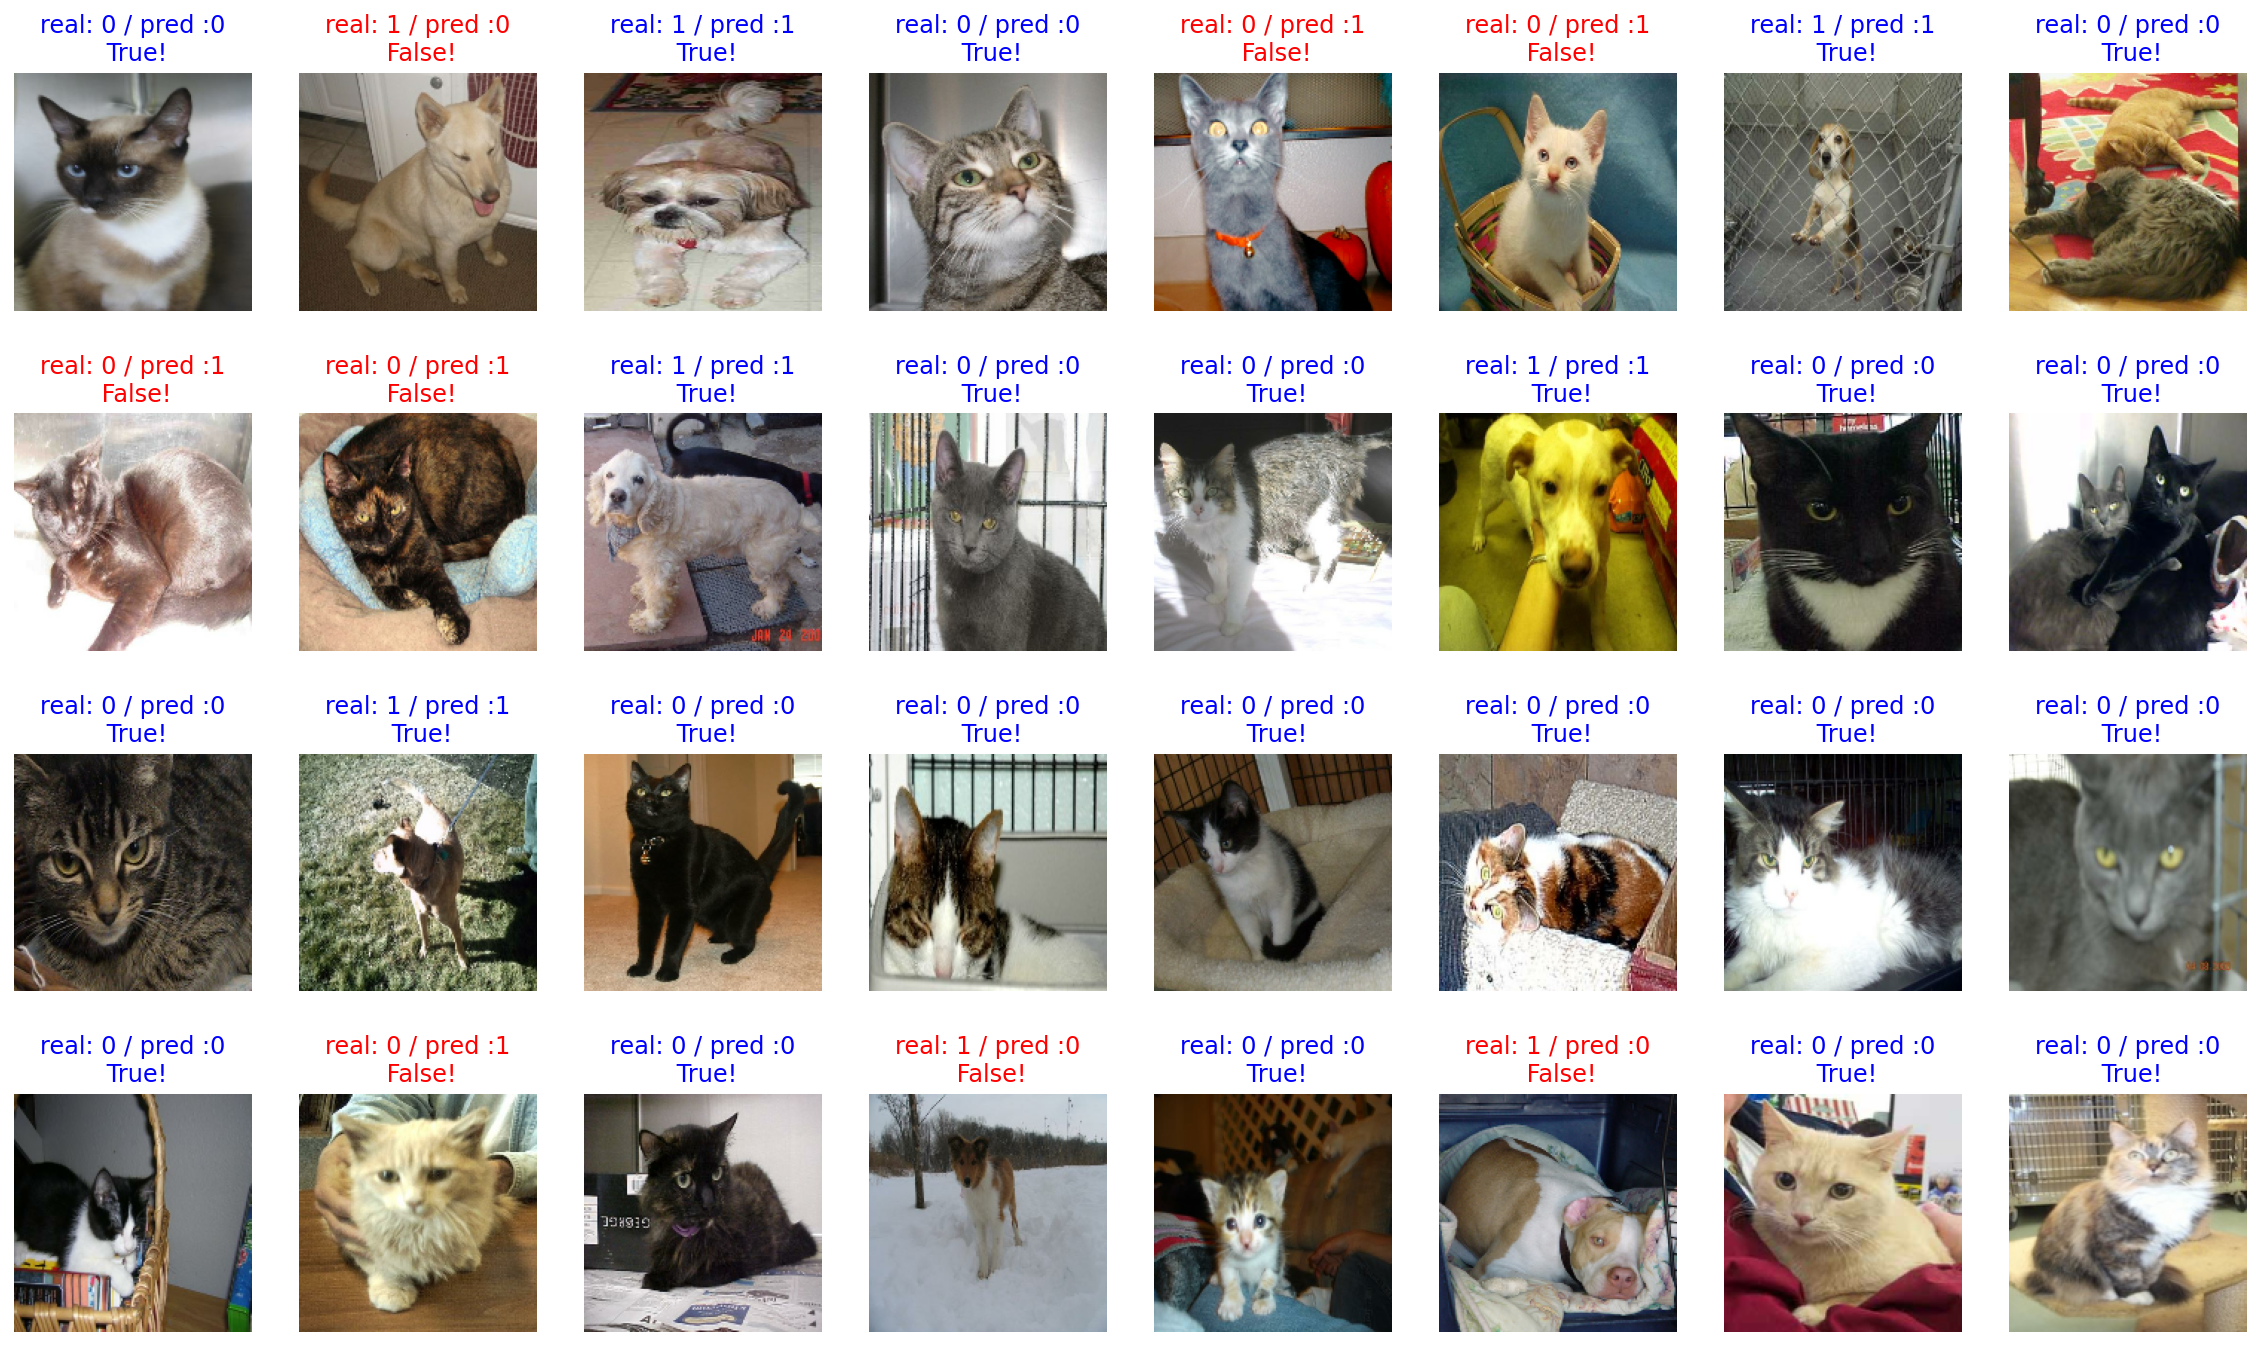

In [27]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [28]:
count = 0   # 정답을 맞춘 개수
for image, label, prediction in zip(images, labels, predictions):
    check = label == prediction
    count += np.sum(check)


print(count / 32 * 100)    # 약 70% 내외

75.0
